Aprendizaje Automático - Práctica 2
Autores: RICARDO ANTONIO PAZOS VALERO - 100472303 / VICENTE ANTONIO BARBATO - 10043114

# 1. K-Means
---
Programamos el algoritmo K-Means y comparamos nuestra implementación con la implementación de sklearn

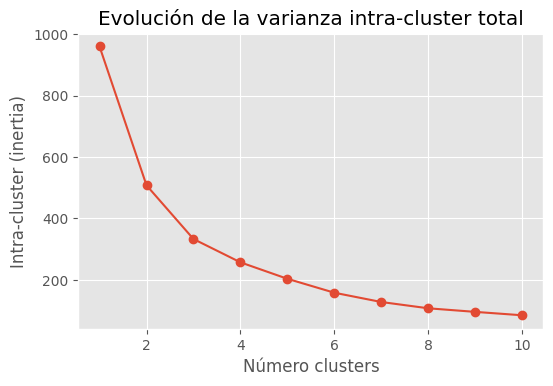

In [495]:
# Importamos
import numpy as np
import pandas as pd
import time

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Desarrollamos nuestro propio K-Means
def distance(p1, p2, metric='manhattan'):
    """Función auxiliar que calcula la distancia entre dos puntos"""
    if metric == 'manhattan':
        return np.sum(np.abs(p1 - p2))
    elif metric == 'euclidean':
        return np.sqrt(np.sum((p1 - p2)**2))
    elif metric == 'minkowski':
        p = 3
        return np.sum(np.abs(p1 - p2)**p)**(1/p)

def myKMeans(X, clusters, k, metric, max_iter=100, tol=1e-4):
    """Nuestra función KMeans"""
    for _ in range(max_iter):
        # Asignamos clusters
        for idx in range(X.shape[0]):
            dist = []
            current_x = X[idx]
            for i in range(k):
                dis = distance(current_x, clusters[i]['center'], metric)
                dist.append(dis)
            curr_cluster = np.argmin(dist)
            clusters[curr_cluster]['points'].append(current_x)

        # Actualizamos clusters
        for i in range(k):
            points = np.array(clusters[i]['points'])
            if points.shape[0] > 0:
                new_center = points.mean(axis =0)
                # Si el cambio en el centroide es menor que la tolerancia, detenemos la iteración
                if np.sum((clusters[i]['center'] - new_center)**2) < tol:
                    return clusters
                clusters[i]['center'] = new_center
                clusters[i]['points'] = []
    return clusters

def myKMeansPred(X, clusters, k):
    """Nuestra función para hacer Predict"""
    # Predecimos los clusters para los datapoints
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

def initialize_clusters(X, k):
    np.random.seed(100572303)  # Establece la semilla del generador de números aleatorios
    clusters = []
    for i in range(k):
        cluster = {
            'center': np.random.uniform(low=X.min(axis=0), high=X.max(axis=0)),  # Inicializa el centroide en un punto aleatorio
            'points': []  # Inicialmente no hay puntos asignados a este cluster
        }
        clusters.append(cluster)
    return clusters

def run_custom_kmeans(X, k, metric):
    clusters = initialize_clusters(X, k)
    clusters = myKMeans(X, clusters, k, metric=metric)
    pred = myKMeansPred(X, clusters, k)
    return pred

def run_sklearn_kmeans(X, k):
    kmeans = KMeans(n_clusters=k, random_state=100572303)
    pred = kmeans.fit_predict(X)
    return pred

def n_clusters_elbow_method():
    range_n_clusters = range(1, 11)
    inertias = []

    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(
            n_clusters   = n_clusters,
            n_init       = 20,
            random_state = 100572303
        )
        modelo_kmeans.fit(X_scaled)
        inertias.append(modelo_kmeans.inertia_)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range_n_clusters, inertias, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster total")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)');

# Cargamos los datos
data = pd.read_csv('data/stars_data.csv')

# Creamos una copia de los datos
X = data.copy()

# Eliminamos columnas no numéricas
X = X.select_dtypes(include=[np.number])

# Escalamos los datos 
X_scaled = scale(X)

#Aplicamos el método del codo para definir el número de clusters a usar
n_clusters_elbow_method()


### Número de Clusters:

Podemos observar mediante la evaluación de la gráfica resultante, que el número de clusters más óptimo a usar sería con un k = 4. Por lo que procedemos a comparar nuestro Kmean, frente al predeterminado de la librería de scikit-learn. Hemos decidido llevar a cabo la comparativa entre las distancia manhattan, euclidiana y minkowski, para poder definir cual nos conviene usar para nuestro conjunto de datos. 

In [496]:
# Definimos número de clusters 
k = 4

# Definimos las métricas de distancia (asi podemos definir que métrica nos conviene mejor)
metrics = ['manhattan', 'euclidean', 'minkowski']

for metric in metrics:
    # Ejecutamos nuestro KMeans personalizado
    start_time = time.time()
    clusters = initialize_clusters(X_scaled, k)
    clusters = myKMeans(X_scaled, clusters, k, metric=metric)
    custom_pred = myKMeansPred(X_scaled, clusters, k)
    custom_time = time.time() - start_time
    custom_silhouette = silhouette_score(X_scaled, custom_pred)

    # Ejecutamos KMeans de scikit-learn
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=100572303)
    sklearn_pred = kmeans.fit_predict(X_scaled)
    sklearn_time = time.time() - start_time
    sklearn_silhouette = silhouette_score(X_scaled, sklearn_pred)

    # Imprimimos los resultados
    print(f"Distancia: {metric}")
    print(f"Tiempo de ejecución (custom): {custom_time:.4f} segundos")
    print(f"Coeficiente de Silhouette (custom): {custom_silhouette:.4f}")
    print(f"Tiempo de ejecución (scikit-learn): {sklearn_time:.4f} segundos")
    print(f"Coeficiente de Silhouette (scikit-learn): {sklearn_silhouette:.4f}")
    print("\n")

Distancia: manhattan
Tiempo de ejecución (custom): 0.0250 segundos
Coeficiente de Silhouette (custom): 0.5392
Tiempo de ejecución (scikit-learn): 0.0012 segundos
Coeficiente de Silhouette (scikit-learn): 0.5423


Distancia: euclidean
Tiempo de ejecución (custom): 0.0137 segundos
Coeficiente de Silhouette (custom): 0.5390
Tiempo de ejecución (scikit-learn): 0.0010 segundos
Coeficiente de Silhouette (scikit-learn): 0.5423


Distancia: minkowski
Tiempo de ejecución (custom): 0.0227 segundos
Coeficiente de Silhouette (custom): 0.5374
Tiempo de ejecución (scikit-learn): 0.0012 segundos
Coeficiente de Silhouette (scikit-learn): 0.5423




### Análisis de datos:

Podemos concluir que ...

# 2. One-hot-encoding
---

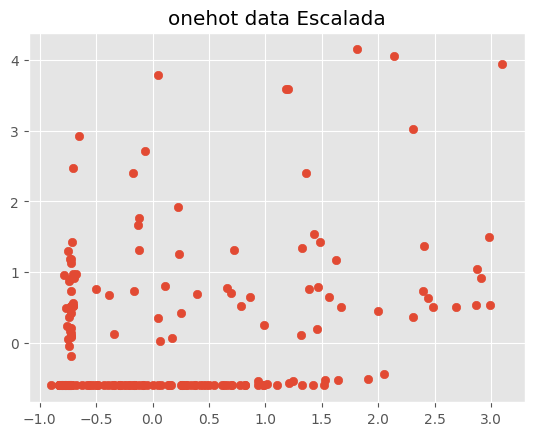

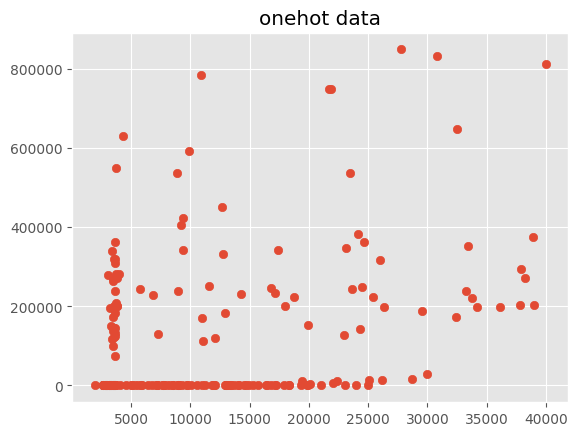

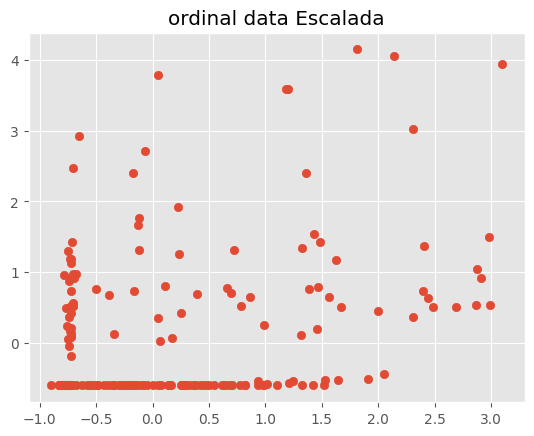

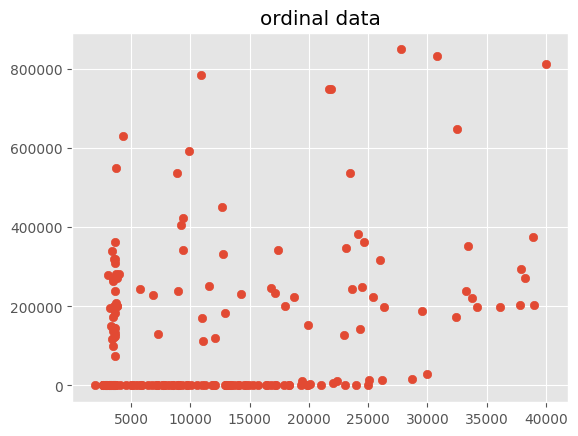

In [497]:
# Importamos
# === Tratamiento de datos =====================================================
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

# === Gráficos =================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# === Preprocesado y modelado ==================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples

# === Configuración warnings ===================================================
import warnings
warnings.filterwarnings('ignore')

# Establecemos una unificación de colores - Obtenido de clase
mapping = {   # Diccionario con formato Target : List of current values
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}


# Mapeamos los datos
for target_color, source_colors in mapping.items():
  data.loc[data.Color.isin(source_colors), 'Color'] = target_color

X = data.values

# Copiamos el conjunto de datos original para preservarlo
X_onehot = X.copy()
X_ordinal = X.copy()

# === Codificamos valores de tipo str (color y clase espectral) ============================
# One-Hot Encoder:
# Definimos el encoder
encoder_onehot = OneHotEncoder(sparse_output=False)

# Definimos las columnas categóricas
onehot_categorical_columns = [-2, -1] 

# Creamos el transformador de columnas
onehot_column_transformer = ColumnTransformer([
    ('onehot', encoder_onehot, onehot_categorical_columns)
])

# Transformamos los datos
X_onehot_encoded = onehot_column_transformer.fit_transform(X_onehot)

# Concatenamos los datos
X_onehot = np.concatenate((X_onehot[:, :-2], X_onehot_encoded), axis=1)

# Ordinal Encoder:
# Definimos listas
spectral_list = ["O", "B", "A", "F", "G", "K", "M"]
colors = list(mapping.keys())

# Definimos el ordinal encoder con las listas
ordinal_encoder = OrdinalEncoder(categories=[colors, spectral_list])

# Definimos las columnas categóricas
ordinal_categorical_columns = [-2, -1]

# Creamos el transformador de columnas
ordinal_column_transformer = ColumnTransformer([
    ('ordinal', ordinal_encoder, ordinal_categorical_columns)
])

# Transformamos los datos
X_ordinal_encoded = ordinal_column_transformer.fit_transform(X_ordinal)

# Concatenamos los datos
X_ordinal = np.concatenate((X_ordinal[:, :-2], X_ordinal_encoded), axis=1)

# Escalamos los datos
X_onehot_scaled = scale(X_onehot)
X_ordinal_scaled = scale(X_ordinal)

# === Representamos data ==========================================================
# Figura para onehot data
fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_onehot_scaled[:,0],X_onehot_scaled[:,1])
plt.title('onehot data Escalada')
plt.show()

fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_onehot[:,0],X_onehot[:,1])
plt.title('onehot data')
plt.show()

# Figura para ordinal data
fig_ordinal_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_ordinal_scaled[:,0],X_ordinal_scaled[:,1])
plt.title('ordinal data Escalada')
plt.show()

fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_ordinal[:,0],X_ordinal[:,1])
plt.title('ordinal data')
plt.show()

### PCA
Bidimensionamos los datos depués de haber aplicado one-hot-encoded

In [498]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits


# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca_onehot_scaled = pca.fit_transform(X_onehot_scaled)
X_pca_onehot = pca.fit_transform(X_onehot)
X_pca_ordinal_scaled = pca.fit_transform(X_ordinal_scaled)
X_pca_ordinal = pca.fit_transform(X_ordinal)


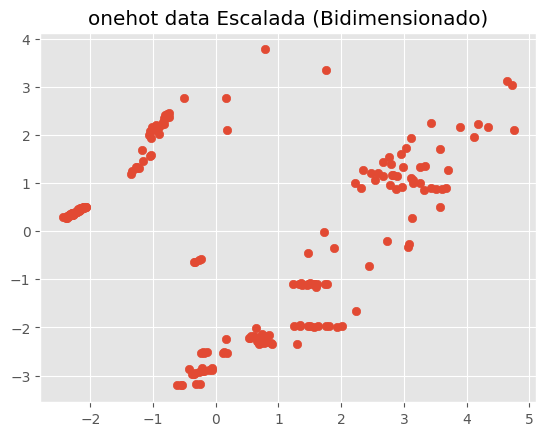

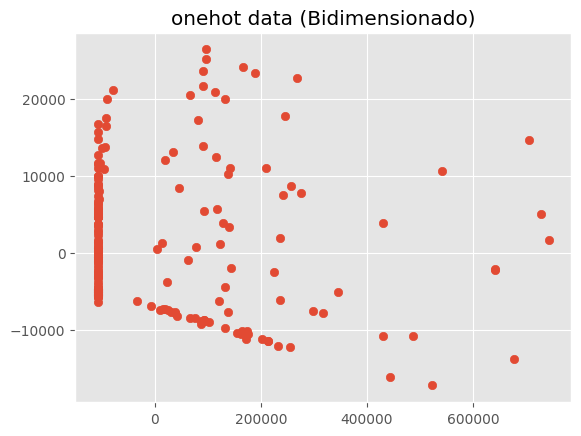

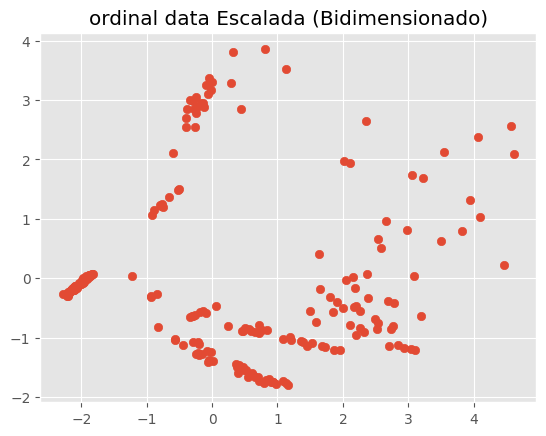

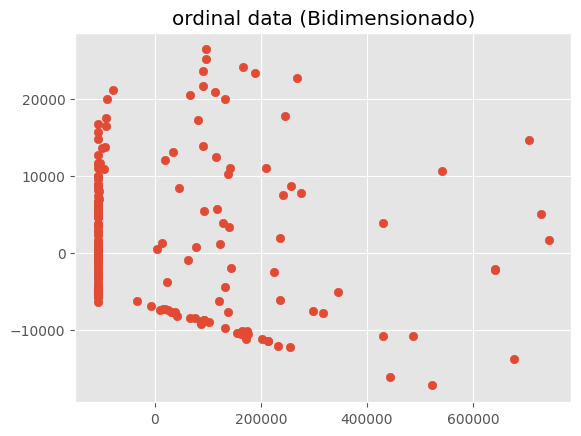

In [499]:
# === Representamos data ==========================================================
# Figura para onehot data
fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_pca_onehot_scaled[:,0],X_pca_onehot_scaled[:,1])
plt.title('onehot data Escalada (Bidimensionado)')
plt.show()

fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_pca_onehot[:,0],X_pca_onehot[:,1])
plt.title('onehot data (Bidimensionado)')
plt.show()

# Figura para ordinal data
fig_ordinal_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_pca_ordinal_scaled[:,0],X_pca_ordinal_scaled[:,1])
plt.title('ordinal data Escalada (Bidimensionado)')
plt.show()

fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_pca_ordinal[:,0],X_pca_ordinal[:,1])
plt.title('ordinal data (Bidimensionado)')
plt.show()

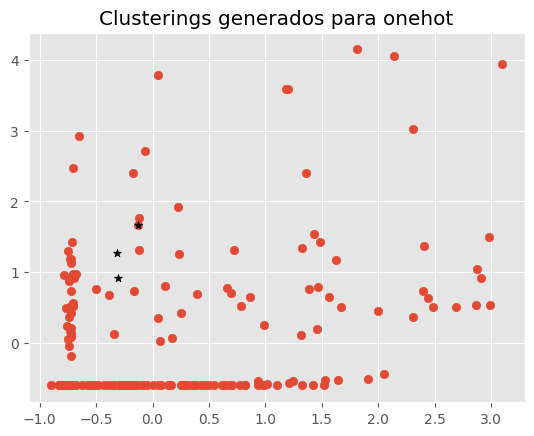

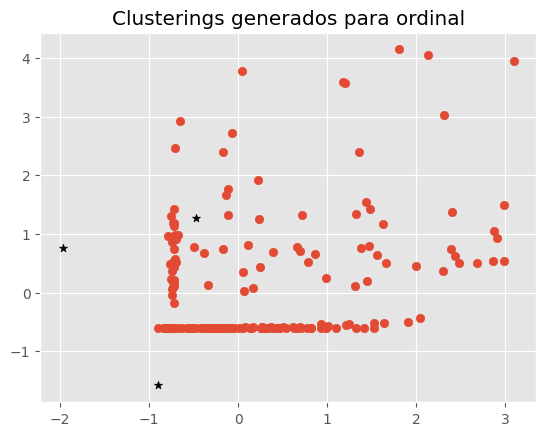

In [500]:
# Inicializamos los centroides para los clusters
k = 3
clusters_onehot = {}
clusters_ordinal = {}
np.random.seed(100572303)

# Clusters con onehot data
for idx in range(k):
    center = 2*(2*np.random.random((X_onehot_scaled.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
     
    clusters_onehot[idx] = cluster

# Clusters con ordinal data
for idx in range(k):
    center = 2*(2*np.random.random((X_ordinal_scaled.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
     
    clusters_ordinal[idx] = cluster

# Representamos la figura para onehot
plt.scatter(X_onehot_scaled[:,0],X_onehot_scaled[:,1])
plt.grid(True)
for i in clusters_onehot:
    center = clusters_onehot[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'black')
plt.title('Clusterings generados para onehot')
plt.show()

# Representamos la figura para ordinal
plt.scatter(X_ordinal_scaled[:,0],X_ordinal_scaled[:,1])
plt.grid(True)
for i in clusters_ordinal:
    center = clusters_ordinal[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'black')
plt.title('Clusterings generados para ordinal')
plt.show()


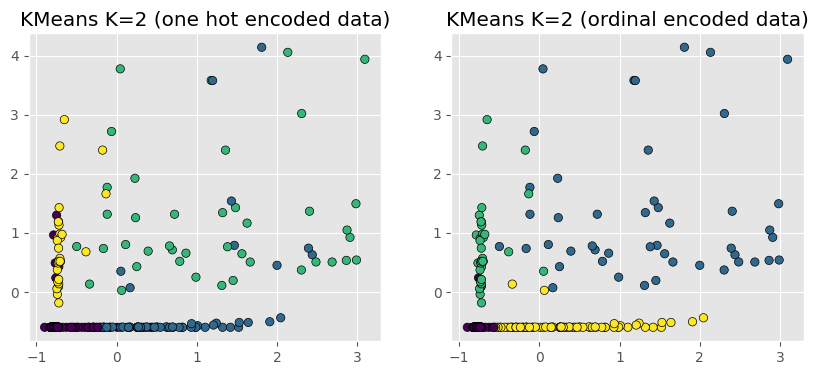

In [501]:
# === KMeans =====================================================================
# Definimos el número de clusters
n_clusters = 4

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# KMeans de sklearn con one hot encoded data
kmeans_onehot = KMeans(n_clusters=n_clusters, random_state=100472303).fit(X=X_onehot_scaled)
cluster_labels_onehot = kmeans_onehot.predict(X_onehot_scaled)  # Sacamos cluster labels
ax[0].scatter(
    x = X_onehot_scaled[:, 0],
    y = X_onehot_scaled[:, 1],
    c = cluster_labels_onehot,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[0].set_title('KMeans K=2 (one hot encoded data)');

# KMeans de sklearn con ordinal encoded data
kmeans_ordinal = KMeans(n_clusters=n_clusters, random_state=100472303).fit(X=X_ordinal_scaled)
cluster_labels_ordinal = kmeans_ordinal.predict(X_ordinal_scaled)  # Sacamos cluster labels
ax[1].scatter(
    x = X_ordinal_scaled[:, 0],
    y = X_ordinal_scaled[:, 1],
    c = cluster_labels_ordinal,
    #cmap='viridis',
    marker    = 'o',
    edgecolor = 'black'
)
ax[1].set_title('KMeans K=2 (ordinal encoded data)');

# 3. Algorimos alternos
---

Hemos decidido aplicar el algoritmo DBSCAN, debido a que al realizar un análisis de las gráficas anteriormente dibujadas, podemos observar que hay una cantidad considerable de outliners, y aplicando dicho algoritmo podemos controlarlos de una mejor forma 

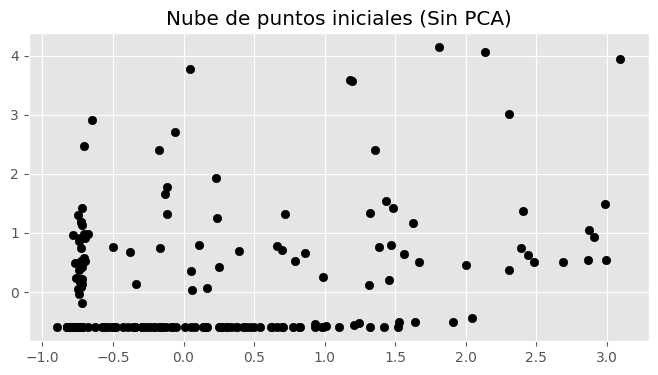

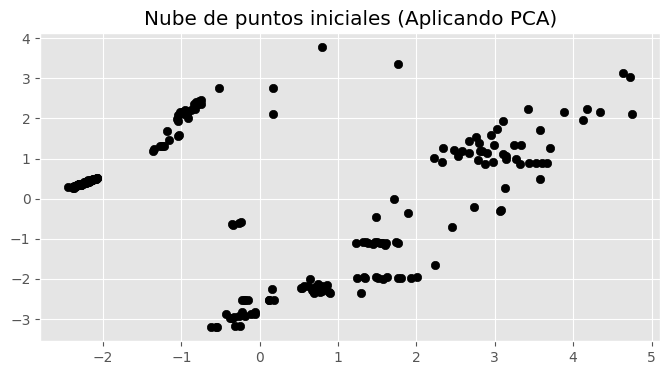

In [511]:
from sklearn.cluster import DBSCAN
# Escalado de datos
# ==============================================================================

# Gráfica sin PCA
plt.figure(figsize=(8, 4))
plt.scatter(
    x = X_onehot_scaled[:, 0],
    y = X_onehot_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
plt.title('Nube de puntos iniciales (Sin PCA)');
plt.show()

# Gráfica con PCA
plt.figure(figsize=(8, 4))
plt.scatter(
    x = X_pca_onehot_scaled[:, 0],
    y = X_pca_onehot_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
plt.title('Nube de puntos iniciales (Aplicando PCA)');
plt.show()

Número de clusters encontrados: 9
Número de outliers encontrados: 63


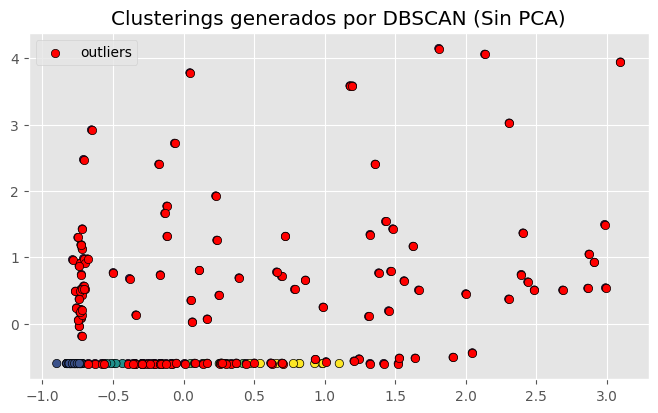

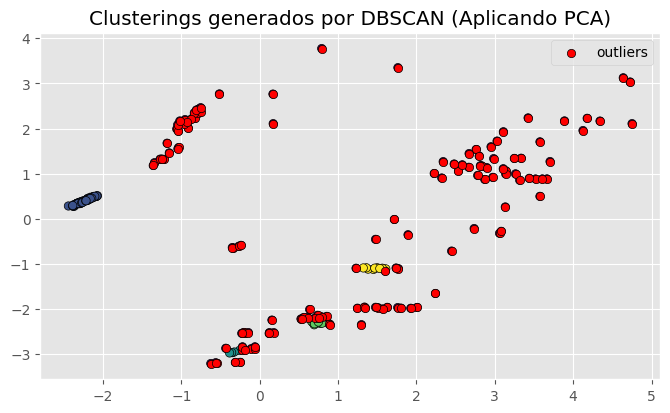

In [503]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_pca_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

X = X_onehot_scaled
X_pca = X_pca_onehot_scaled

modelo_dbscan.fit(X)
modelo_pca_dbscan.fit(X_pca)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_
labels_pca = modelo_pca_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

ax.scatter(
    x = X[:, 0],
    y = X[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X[labels == -1, 0],
    y = X[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN (Sin PCA)');


fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

ax.scatter(
    x = X_pca[:, 0],
    y = X_pca[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_pca[labels == -1, 0],
    y = X_pca[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN (Aplicando PCA)');

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels_pca)) - (1 if -1 in labels_pca else 0)
n_noise    = list(labels_pca).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

In [504]:
# Número de clusters y observaciones "outliers" sin aplicar PCA
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados (Sin PCA): {n_clusters}')
print(f'Número de outliers encontrados (Sin PCA): {n_noise}')

# Número de clusters y observaciones "outliers aplicando PCA"
# ==============================================================================
n_clusters = len(set(labels_pca)) - (1 if -1 in labels_pca else 0)
n_noise    = list(labels_pca).count(-1)

print(f'Número de clusters encontrados (Aplicando PCA): {n_clusters}')
print(f'Número de outliers encontrados (Aplicando PCA): {n_noise}')

Número de clusters encontrados (Sin PCA): 4
Número de outliers encontrados (Sin PCA): 137
Número de clusters encontrados (Aplicando PCA): 9
Número de outliers encontrados (Aplicando PCA): 63
